In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV,train_test_split
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X_train = pd.read_csv('X_train.csv',index_col = 0)
X_predict= pd.read_csv('X_predict.csv',index_col = 0)
y = pd.read_csv('y.csv',header = None,  names=['Id', 'price'],index_col = 0).iloc[:,0]

# Validation function and grid search 

In [3]:
n_folds = 5

def rmsle_cv(model,x_in):
    kf = KFold(n_folds, shuffle=True).get_n_splits(x_in)
    rmse= np.sqrt(-cross_val_score(model, x_in, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,x_in,param_grid):
        kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_in)
        grid_search = GridSearchCV(self.model,param_grid,cv=kf, scoring="neg_mean_squared_error", n_jobs=-1,verbose=2)
        grid_search.fit(x_in, y_train.values)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])


# Examing num of feature used in the test

In [5]:
train, test, y_train, y_test = train_test_split(X_train, y, test_size=0)

In [7]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0006))

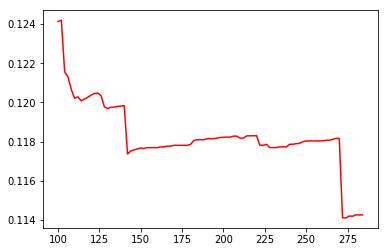

In [8]:
np.seterr(divide='ignore', invalid='ignore')
num_feats_ = np.arange(100,286,2)
cv_score = []
test_score = []
for num_feats in num_feats_: 
    X_new = SelectKBest(f_regression, k= num_feats).fit_transform(train.values, y_train.values)
    
    kf = KFold(n_folds, shuffle=True).get_n_splits(X_new)
    score= np.sqrt(-cross_val_score(lasso, X_new, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    cv_score.append(score.mean())
    

plt.plot(num_feats_,cv_score,'r')

In [ ]:
# Using 580 features to do the training 

# Lasso 

In [15]:
#grid(Lasso()).grid_get(train.values,{'alpha': [0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007]})

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0004, random_state=1))
score= rmsle_cv(lasso,train.values)
print("Lasso score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))

Lasso score: 0.11402 (0.00766)



# Elastic Net Regression :

In [17]:
#grid(ElasticNet()).grid_get(X_new,{'alpha': [0.0006,0.0007,0.0008,0.0009],'l1_ratio':[0.8,0.9,1,1.1],'max_iter':[700,800,900,1000,1100]})

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0004, l1_ratio=1.4,max_iter = 600))

score = rmsle_cv(ENet,train.values)
print("ElasticNet score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.11414 (0.00751)



# Kernel Ridge Regression :

In [18]:
# grid(KernelRidge()).grid_get(X_new,[{'kernel': ['linear'],'alpha':np.logspace(-4,4,8)},{'kernel': ['polynomial'],'alpha':np.logspace(-4,4,8),'degree':np.logspace(-4,4,8),'coef0':np.logspace(-4,4,8)}])

KRR = KernelRidge(alpha=0.04, kernel='polynomial', degree=1, coef0=0.0008)

score = rmsle_cv(KRR,train.values)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1154 (0.0080)



# KNeighborsRegressor

In [19]:
#grid(KNeighborsRegressor()).grid_get(X_new,{'n_neighbors':np.arange(5,50,5), 'weights':['uniform','distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 'leaf_size':np.arange(5,50,5), 'p':np.arange(2,20,2)})


KNN = make_pipeline(RobustScaler(), KNeighborsRegressor(n_neighbors=6, weights = 'distance',algorithm='brute', p=1, leaf_size=1))

score = rmsle_cv(KNN,train.values)
print("KNN score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))

KNN score: 0.16454 (0.01919)



# SVR

In [ ]:
#grid(SVR()).grid_get(X_new,{'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'degree':[1,2,3,4,5], 'coef0':[0.0,0.1,0.2,1,10],'C':[0.01,0.1,1.0,10], 'epsilon':[0.01,0.1,1,10]})

#{'coef0': 0.0, 'epsilon': 0.02, 'kernel': 'linear', 'C': 0.004, 'degree': 1} 0.11325162650394656

# SVR = make_pipeline(RobustScaler(), SVR(kernel='poly', degree=1, coef0=1,C=9.0, epsilon=0.01))

# score = rmsle_cv(SVR,X_new)
# print("SVR score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))

# Random forest Regression

In [20]:
#grid(RandomForestRegressor()).grid_get(X_new,{'n_estimators':[100,1000,5000], 'max_depth':[None,2,5,10,20], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,3,5,10], 'max_features':[0.01,0.05,0.1,0.5,1]})


RF = make_pipeline(RobustScaler(), RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=0.3))

score = rmsle_cv(RF,train.values)
print("RF score: {:.5f} ({:.5f})\n".format(score.mean(), score.std()))


RF score: 0.13041 (0.01426)



# Gradient Boosting Regression :

In [21]:
#{'min_samples_leaf': 4, 'max_features': 0.04, 'min_samples_split': 30, 'n_estimators': 3700, 'learning_rate': 0.01, 'max_depth': 3, 'loss': 'ls'} 0.1122755329486732

GBoost = GradientBoostingRegressor(n_estimators=3700, learning_rate=0.04,
                                   max_depth=3, max_features=0.04,
                                   min_samples_leaf=4, min_samples_split=30, 
                                   loss='ls')
score = rmsle_cv(GBoost,train.values)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1151 (0.0097)



# XGBoost:

In [22]:
#grid(xgb.XGBRegressor()).grid_get({'colsample_bytree':[0.1,0.4603], 'gamma':[0.01,0.0468], 'learning_rate':[0.01,0.05], 'max_depth':[3,10], 'min_child_weight':[1.7817,10], 'n_estimators':[2000,5200],'reg_alpha':[0.4640,1], 'reg_lambda':[0.5,0.9],'subsample':[0.1,0.5213]})

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817, n_estimators=5200,reg_alpha=0.4640, reg_lambda=0.9,subsample=0.5213, silent=1,nthread = -1)

score = rmsle_cv(model_xgb,train.values)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1156 (0.0120)



# LightGBM :

In [23]:
#grid(lgb.LGBMRegressor()).grid_get(X_new,{'num_leaves':[3],'learning_rate':[0.05], 'n_estimators':[1000],'max_bin' : [220,250,270], 'bagging_fraction' : [0.8],'bagging_freq' : [12,14,16,18], 'feature_fraction' : [0.1],'min_data_in_leaf' :[4,5,6], 'min_sum_hessian_in_leaf' : [2,4,6,8]})

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=3,learning_rate = 0.05, n_estimators=1000, max_bin = 250, bagging_fraction = 0.8,bagging_freq = 16, feature_fraction = 0.1,bagging_seed=9,min_data_in_leaf =5, min_sum_hessian_in_leaf = 2)


score = rmsle_cv(model_lgb,train.values)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1157 (0.0095)



### Stacking models

#### Simplest Stacking approach : Averaging base models

In [24]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [27]:
averaged_models = AveragingModels(models = (lasso,ENet, KRR, GBoost,model_xgb, model_lgb))

score = rmsle_cv(averaged_models,train.values)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0091)



#### Less simple Stacking : Adding a Meta-model

In [28]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [33]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso, GBoost, KRR),
                                                 meta_model = ENet)

score = rmsle_cv(stacked_averaged_models,train.values)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1089 (0.0089)


# submission

In [37]:
train.shape

(1457, 287)

In [39]:
stacked_averaged_models.fit(train.values, y_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_predict))

In [45]:
model_xgb.fit(train.values, y_train.values)

model_xgb_pred = np.expm1(model_xgb.predict(X_predict.values))

In [46]:
model_lgb.fit(train.values, y_train.values)
model_lgb_pred = np.expm1(model_lgb.predict(X_predict.values))

In [47]:
ensemble = stacked_pred*0.8 + model_xgb_pred*0.1 + model_lgb_pred*0.1

submission_df = pd.DataFrame(data= {'Id' :X_predict.index, 'SalePrice': ensemble})

submission_df.head()

submission_df.to_csv('submit.csv', index=False)